In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [7]:
mumbai = pd.read_csv("Data/mumbai.csv")

In [8]:
data = (mumbai[["PROPERTY_TYPE", "CITY", "OWNTYPE", 
                "BEDROOM_NUM", "FURNISH", "FACING", "AGE", "CLASS", "MAX_PRICE", 
                "PRICE_SQFT", "MAX_AREA_SQFT", "MAP_DETAILS"]])
data.dropna(inplace=True)

In [15]:
data[["lat", "lon"]] = mumbai["MAP_DETAILS"].str.split(",", expand=True)
data["lat"] = data["lat"].str[12:].str.replace("'", "").astype(float)
data["lon"] = data["lon"].str[13:].str.replace("'", "").str.replace("}", "").astype(float)
# Filters to remove errors in data and outliers
data = data[data['MAX_PRICE'] > 100000]
data = data[data['PRICE_SQFT'] < 100000]
data = data[data['lon'] > 50]
data = data[data['lon'] < 76]
data = data[data['lat'] > 18.7]
data.drop(columns=["MAP_DETAILS"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6680 entries, 17 to 9513
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PROPERTY_TYPE  6680 non-null   object 
 1   CITY           6680 non-null   object 
 2   OWNTYPE        6680 non-null   int64  
 3   BEDROOM_NUM    6680 non-null   float64
 4   FURNISH        6680 non-null   int64  
 5   FACING         6680 non-null   int64  
 6   AGE            6680 non-null   int64  
 7   CLASS          6680 non-null   object 
 8   MAX_PRICE      6680 non-null   int64  
 9   PRICE_SQFT     6680 non-null   float64
 10  MAX_AREA_SQFT  6680 non-null   float64
 11  lat            6680 non-null   float64
 12  lon            6680 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 730.6+ KB


<Axes: >

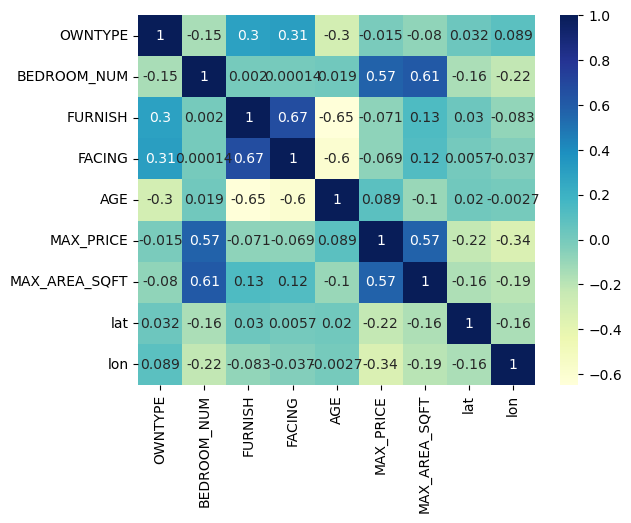

In [16]:
numerics = data.drop(columns=["PROPERTY_TYPE", "CITY", "CLASS", "PRICE_SQFT"])
numerics.corr()
sns.heatmap(numerics.corr(), cmap="YlGnBu", annot=True)

<Axes: >

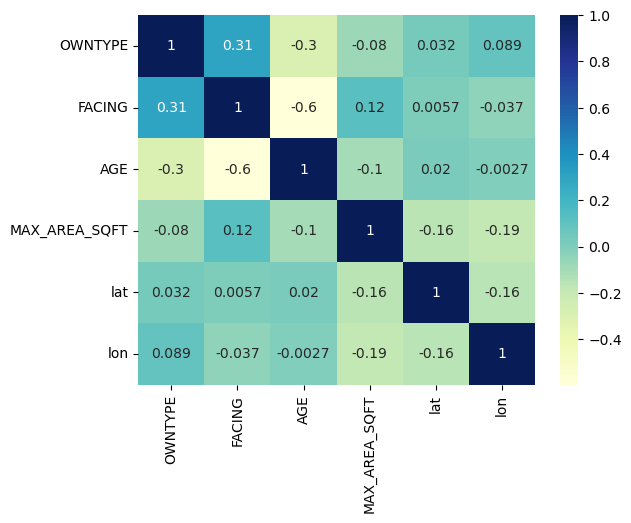

In [17]:
data.drop(columns=["MAX_PRICE", "FURNISH", "BEDROOM_NUM"], inplace=True)
numerics = data.drop(columns=["PROPERTY_TYPE", "CITY", "CLASS", "PRICE_SQFT"])
sns.heatmap(numerics.corr(), cmap="YlGnBu", annot=True)

In [47]:
import plotly.express as px
fig = px.scatter_mapbox(
    data,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="PRICE_SQFT",
    hover_data=["PRICE_SQFT"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [150]:
# Create 3D scatter plot
fig = px.scatter_3d(
    data,
    x="lat",
    y="lon",
    z="PRICE_SQFT",
    labels={"lon": "Longitude", "lat": "Latitude", "PRICE_SQFT": "Price per Sq. ft."},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

In [35]:
x = numerics
y = data["PRICE_SQFT"]
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6680 entries, 17 to 9513
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OWNTYPE        6680 non-null   int64  
 1   FACING         6680 non-null   int64  
 2   AGE            6680 non-null   int64  
 3   MAX_AREA_SQFT  6680 non-null   float64
 4   lat            6680 non-null   float64
 5   lon            6680 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 365.3 KB


In [36]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=104, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5344, 6), (1336, 6), (5344,), (1336,))

In [39]:
#Baseline Prediction Score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
baseline_mae

11671.402175112724

In [40]:
model = Ridge()
model.fit(X_train,y_train)
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 8908.744506354105


In [41]:
y_pred_test = model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

Test MAE: 8494.337031867131


In [45]:
feat_imp = pd.Series(model.coef_, index=model.feature_names_in_)
feat_imp

OWNTYPE           3852.058138
FACING           -1269.158389
AGE               1629.684865
MAX_AREA_SQFT       13.070634
lat             -41565.100073
lon             -75451.707594
dtype: float64

Test MAE and Train MAE are way better than baseline MAE showing the model predictions are good.

In [27]:
X = data.drop(columns=["PRICE_SQFT"])
y = data["PRICE_SQFT"]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104, test_size=0.2, shuffle=True)
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
model2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model2.fit(X_train, y_train)
y_pred_training = model2.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 8310.29404793495


In [31]:
model2.named_steps["ridge"].coef_

array([ 2.24566412e+03,  1.45890933e+03, -3.40025879e+01, -1.26179300e+03,
       -2.40877786e+03, -3.31999691e+03, -1.79993373e+03,  9.11104871e+03,
       -2.01637453e+03,  1.55234433e+03, -3.85899061e+03,  1.26990513e+04,
        3.31310944e+03, -1.56802580e+04,  4.60937296e+03, -1.50195919e+03,
        1.56042773e+03, -1.03105477e+03,  2.12477964e+03, -1.09372487e+03,
        7.50356142e+00, -1.00318264e+04, -5.75224193e+04])

In [32]:
coefficients = model2.named_steps["ridge"].coef_
features = model2.named_steps["onehotencoder"].get_feature_names()
feat_importance = pd.Series(coefficients, index=features)
feat_importance

c:\Users\White House\anaconda3\Lib\site-packages\category_encoders\utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


PROPERTY_TYPE_Residential Apartment         2245.664118
PROPERTY_TYPE_Studio Apartment              1458.909333
PROPERTY_TYPE_Independent House/Villa        -34.002588
PROPERTY_TYPE_Independent/Builder Floor    -1261.793002
PROPERTY_TYPE_Serviced Apartments          -2408.777861
CITY_Mumbai Andheri-Dahisar                -3319.996906
CITY_Thane                                 -1799.933727
CITY_South Mumbai                           9111.048706
CITY_Navi Mumbai                           -2016.374532
CITY_Central Mumbai suburbs                 1552.344327
CITY_Mumbai Beyond Thane                   -3858.990609
CITY_Mumbai South West                     12699.051345
CITY_Mumbai Harbour                         3313.109437
CITY_Mira Road And Beyond                 -15680.258040
OWNTYPE                                     4609.372965
FACING                                     -1501.959195
AGE                                         1560.427731
CLASS_O                                    -1031

<Axes: title={'center': 'Feature Importances for Price / Sq Ft'}, xlabel='Importance [INR]', ylabel='Feature'>

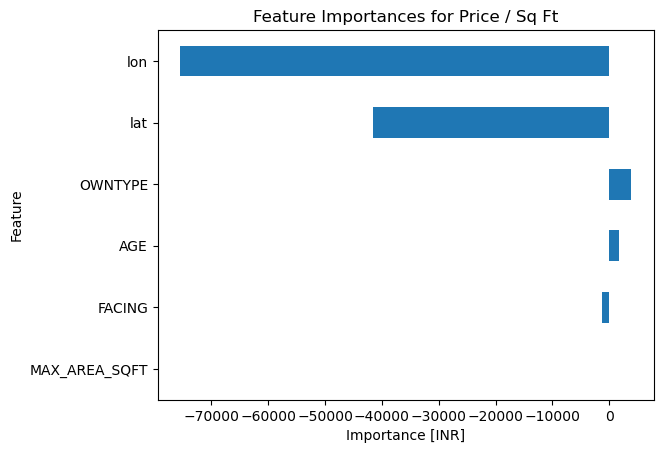

In [46]:
feat_importance.sort_values(key=abs).tail(10).plot(kind="barh", xlabel="Importance [INR]", ylabel= "Feature", title="Feature Importances for Price / Sq Ft")



Real Estate is about location, location and legal holding structure.

OWNTYPE above defined as
1 - Freehold, 2	- Leasehold, 3 - Co-operative Society, 4 - Power of Attorney
